# Time Series Classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
from tslearn.utils import to_time_series_dataset, save_time_series_txt, load_time_series_txt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
import pickle

In [2]:
data_path = '/home/mattiapggioli/lyrics2ts/data/classification/20ng/sbert/'
truncate=100
max_iter = 2000
paa_window_size = None
undersampling = None

In [3]:
# Parameters
data_path = "/home/mattiapggioli/lyrics2ts/data/classification/movie-plots/features/"


In [4]:
ts = load_time_series_txt(f'{data_path}/ts.txt')

In [5]:
ts.shape

(7512, 412, 1)

In [6]:
with open(f'{data_path}/y_class.npy', 'rb') as f:
    y = np.load(f, allow_pickle=True)

In [7]:
with open(f'{data_path}/X.npy', 'rb') as f:
    X = np.load(f, allow_pickle=True)

In [8]:
X.shape

(7512, 14)

In [9]:
set(y)

{'action_thriller_crime',
 'comedy',
 'drama',
 'horror_scifi_mystery_supernatural_fantasy'}

In [10]:
ts_train, ts_test, y_train, y_test = train_test_split(ts, y, test_size=0.20, random_state=42)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [12]:
random.choice(ts_train)

array([[ 1.86039276],
       [ 2.32315676],
       [ 2.67880123],
       [ 3.61134811],
       [ 4.323401  ],
       [ 3.45389575],
       [-3.53261869],
       [ 0.10468503],
       [ 4.12313014],
       [-1.45464178],
       [-0.94172804],
       [ 0.32479626],
       [-3.46509204],
       [ 2.0828257 ],
       [-2.33922413],
       [-0.37953112],
       [ 0.23859839],
       [ 2.42127679],
       [-1.19017792],
       [-0.476132  ],
       [ 1.23869496],
       [-2.42426544],
       [ 1.06151125],
       [-2.15494845],
       [-0.65920256],
       [ 2.12484754],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [        nan],
       [  

<AxesSubplot:ylabel='Count'>

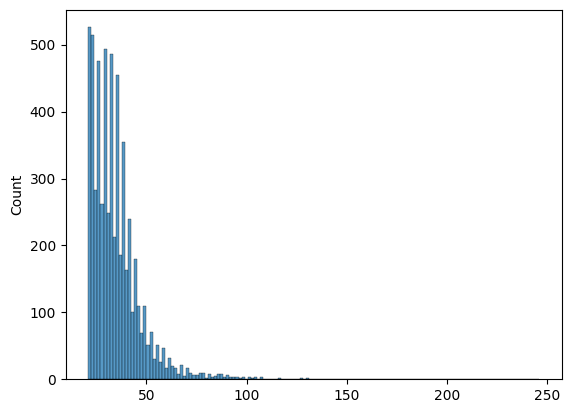

In [13]:
sns.histplot([t[~np.any(np.isnan(t), axis=1)].shape[0] for t in ts_train])

In [14]:
ts_train = ts_train[:, :truncate, :]
ts_test = ts_test[:, :truncate, :]

In [15]:
mean_arr = np.nanmean(ts_train, axis=1, keepdims=True)
nan_indices = np.isnan(ts_train)
ts_train[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

mean_arr = np.nanmean(ts_test, axis=1, keepdims=True)
nan_indices = np.isnan(ts_test)
ts_test[nan_indices] = np.take(mean_arr, np.nonzero(nan_indices)[0])

In [16]:
np.count_nonzero(np.isnan(X_train))

0

In [17]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [18]:
save_time_series_txt(f'{data_path}/ts_train.txt', ts_train)
save_time_series_txt(f'{data_path}/ts_test.txt', ts_test)

In [19]:
with open(f'{data_path}/X_train.npy', 'wb') as f:
    np.save(f, X_train, allow_pickle=True)

with open(f'{data_path}/X_test.npy', 'wb') as f:
    np.save(f, X_test, allow_pickle=True)

In [20]:
with open(f'{data_path}/y_train.npy', 'wb') as f:
    np.save(f, y_train, allow_pickle=True)

with open(f'{data_path}/y_test.npy', 'wb') as f:
    np.save(f, y_test, allow_pickle=True)

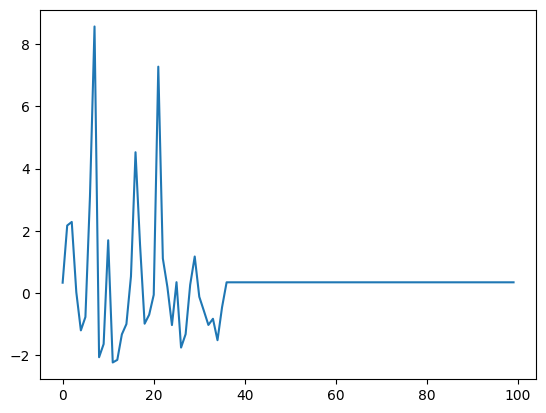

In [21]:
plt.plot(random.choice(ts_train))

In [22]:
# Parameters that require knowing if it's binary or multiclass (LightGBM, metrics)
if len(set(y)) == 2:
    avg_par = 'binary'
    obj_par = 'binary'
elif len(set(y)) > 2:
    avg_par = 'macro'
    obj_par = 'multiclass'

## Classification

In [23]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

In [24]:
metrics_data = {}

### Baseline: global features (No Time Series)

In [25]:
metrics_data['Global'] = {}

**Decision Tree**

In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.27      0.27      0.27       306
                                   comedy       0.30      0.30      0.30       404
                                    drama       0.38      0.38      0.38       494
horror_scifi_mystery_supernatural_fantasy       0.27      0.26      0.27       299

                                 accuracy                           0.32      1503
                                macro avg       0.31      0.31      0.31      1503
                             weighted avg       0.32      0.32      0.32      1503



In [28]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [29]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.37      0.33      0.35       306
                                   comedy       0.38      0.42      0.40       404
                                    drama       0.40      0.56      0.47       494
horror_scifi_mystery_supernatural_fantasy       0.45      0.14      0.21       299

                                 accuracy                           0.39      1503
                                macro avg       0.40      0.36      0.36      1503
                             weighted avg       0.40      0.39      0.37      1503



In [31]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [32]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [33]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.34      0.33      0.34       306
                                   comedy       0.37      0.41      0.39       404
                                    drama       0.41      0.51      0.46       494
horror_scifi_mystery_supernatural_fantasy       0.39      0.20      0.26       299

                                 accuracy                           0.39      1503
                                macro avg       0.38      0.36      0.36      1503
                             weighted avg       0.38      0.39      0.38      1503



In [34]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Global']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

### Time Series Classification

#### Learning Shapelets

In [35]:
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

2023-03-08 14:08:16.514931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 14:08:16.671400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 14:08:16.671421: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2023-03-08 14:08:17.284165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-08 14:08:17.284236: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-08 14:08:17.284246: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [36]:
n_ts, ts_sz, _ = ts_train.shape
n_classes = len(set(y_train))

In [37]:
# Set the number of shapelets per size as done in the original paper
g_shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                         ts_sz=ts_sz,
                                                         n_classes=n_classes,
                                                         l=0.1,
                                                         r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', g_shapelet_sizes)

n_ts 6009
ts_sz 100
n_classes 4
shapelet_sizes {10: 6}


In [38]:
shapelet_sizes = {}
for key in g_shapelet_sizes:
    shapelet_sizes[key] = g_shapelet_sizes[key]
    shapelet_sizes[key*2] = g_shapelet_sizes[key]
    shapelet_sizes[key//2] = g_shapelet_sizes[key]
shapelet_sizes

{10: 6, 20: 6, 5: 6}

In [39]:
model = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                          optimizer="adam", 
                          weight_regularizer=.01, 
                          max_iter=max_iter, verbose=0, random_state=42)

/home/mattiapggioli/lyrics2ts/.venv/lib/python3.9/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


In [40]:
%%time
model.fit(ts_train, y_train)

2023-03-08 14:08:18.479245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 14:08:18.479271: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 14:08:18.479293: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mattiapggioli-ThinkPad-E595): /proc/driver/nvidia/version does not exist
2023-03-08 14:08:18.479500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 47min, sys: 2min 38s, total: 49min 38s
Wall time: 8min 35s


LearningShapelets(max_iter=2000, n_shapelets_per_size={5: 6, 10: 6, 20: 6},
                  optimizer='adam', random_state=42, weight_regularizer=0.01)

In [41]:
model.to_pickle(f'{data_path}/shapelets.pkl')

#### Shapelet-Based Classification

In [42]:
metrics_data['Shapelets'] = {}

In [43]:
X_train = model.transform(ts_train)
X_test = model.transform(ts_test)

In [44]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.669806,0.342048,3.732317,0.788925,1.557584,2.494589,2.351604,2.417738,0.410697,1.369104,1.417955,1.178363,0.672506,1.392516,2.490014,2.783737,2.831360,5.478542
1,0.194041,1.800201,5.300422,1.087766,1.534633,1.673100,2.808507,2.754308,0.638258,0.795166,0.472939,2.032518,0.768980,0.259240,1.629291,1.733302,0.940678,3.370998
2,0.265672,1.194657,1.697560,1.296039,1.678846,2.365921,1.702671,3.930382,1.911226,0.984821,0.732423,2.207443,2.028702,0.333091,2.341087,2.108006,0.325219,1.863970
3,0.546201,1.888287,3.296814,0.380556,2.107292,1.198581,2.325215,2.160794,0.495997,1.042629,0.521021,2.185310,0.727601,0.321241,1.805403,1.821878,1.085502,3.812625
4,0.586650,2.081795,5.609172,0.610526,1.268346,1.696453,3.267632,1.490422,0.602423,1.073779,0.430975,2.459133,0.702020,0.349484,1.655338,2.022692,1.145979,3.835506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1498,1.484398,0.766003,4.263445,1.087112,1.712235,2.775443,3.957447,2.881092,0.473269,2.469877,1.672784,3.102500,0.764259,1.677209,1.941196,2.697076,3.231604,6.986820
1499,0.797517,0.291889,8.020877,1.485258,3.204240,7.038062,7.126567,3.622429,0.506210,2.472104,1.730866,3.956267,1.536391,3.311917,4.116160,4.587492,5.382909,8.993551
1500,1.167965,0.736958,6.249460,1.285258,1.548120,3.002722,4.865162,1.090127,0.379184,1.607442,0.943464,2.744792,0.573759,0.849217,1.899375,2.638116,2.021819,5.377409
1501,0.212217,0.747290,2.935825,1.165573,1.946869,1.639024,1.614838,2.164609,1.490468,0.857614,0.516071,1.641415,1.451506,0.182818,1.689103,1.548236,0.430631,2.173967


**Decision Tree**

In [45]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.21      0.23      0.22       306
                                   comedy       0.27      0.28      0.28       404
                                    drama       0.33      0.31      0.32       494
horror_scifi_mystery_supernatural_fantasy       0.26      0.25      0.26       299

                                 accuracy                           0.27      1503
                                macro avg       0.27      0.27      0.27      1503
                             weighted avg       0.28      0.27      0.27      1503



In [47]:
pickle.dump(clf, open(f'{data_path}/decision_tree.pkl', 'wb'))

In [48]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['DecisionTree'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Random Forest**

In [49]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.24      0.11      0.15       306
                                   comedy       0.32      0.38      0.35       404
                                    drama       0.33      0.51      0.40       494
horror_scifi_mystery_supernatural_fantasy       0.35      0.11      0.17       299

                                 accuracy                           0.32      1503
                                macro avg       0.31      0.28      0.27      1503
                             weighted avg       0.31      0.32      0.29      1503



In [51]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['RandomForest'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**LightGBM**

In [52]:
clf = lgbm.LGBMClassifier(objective=obj_par) 
clf.fit(X_train, y_train)

LGBMClassifier(objective='multiclass')

In [53]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.25      0.13      0.17       306
                                   comedy       0.30      0.37      0.33       404
                                    drama       0.34      0.50      0.41       494
horror_scifi_mystery_supernatural_fantasy       0.26      0.11      0.16       299

                                 accuracy                           0.31      1503
                                macro avg       0.29      0.28      0.27      1503
                             weighted avg       0.30      0.31      0.29      1503



In [54]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['Shapelets']['LightGBM'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

#### KNN

In [55]:
X_train = ts_train.reshape((ts_train.shape[0], ts_train.shape[1]))
X_test = ts_test.reshape((ts_test.shape[0], ts_test.shape[1]))

In [56]:
X_train.shape

(6009, 100)

In [57]:
metrics_data['KNN'] = {}

**Euclidean Distance**

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
clf = KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [60]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.23      0.24      0.23       306
                                   comedy       0.30      0.39      0.34       404
                                    drama       0.34      0.42      0.38       494
horror_scifi_mystery_supernatural_fantasy       0.20      0.04      0.06       299

                                 accuracy                           0.30      1503
                                macro avg       0.27      0.27      0.25      1503
                             weighted avg       0.28      0.30      0.28      1503



In [61]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['Euclidean'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

**Dynamic Time Warping**

In [62]:
from pyts.classification import KNeighborsClassifier
from pyts.approximation import PiecewiseAggregateApproximation
from imblearn.under_sampling import ClusterCentroids
from sklearn_extra.cluster import KMedoids

In [63]:
if paa_window_size:
    paa = PiecewiseAggregateApproximation(window_size=paa_window_size)
    X_train = paa.transform(X_train)
    X_test = paa.transform(X_test)
    X_train.shape

In [64]:
if undersampling:
    total_samples = len(y_train)
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    samp_strat = dict(zip(unique_classes, np.floor(class_counts * undersampling).astype(int)))
    print(samp_strat)
    cc = ClusterCentroids(estimator=KMedoids(
        random_state=42), sampling_strategy=samp_strat, random_state=42)
    X_train, y_train = cc.fit_resample(X_train, y_train)
    X_train.shape

In [65]:
clf = KNeighborsClassifier(metric='dtw_sakoechiba',  metric_params={'window_size':3})

clf.fit(X_train, y_train)

KNeighborsClassifier(metric='dtw_sakoechiba', metric_params={'window_size': 3})

In [66]:
%%time
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                                           precision    recall  f1-score   support

                    action_thriller_crime       0.23      0.25      0.24       306
                                   comedy       0.28      0.28      0.28       404
                                    drama       0.31      0.32      0.32       494
horror_scifi_mystery_supernatural_fantasy       0.22      0.19      0.21       299

                                 accuracy                           0.27      1503
                                macro avg       0.26      0.26      0.26      1503
                             weighted avg       0.27      0.27      0.27      1503

CPU times: user 27min, sys: 44 ms, total: 27min
Wall time: 26min 59s


In [67]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

metrics_data['KNN']['DTW'] = {'Accuracy': acc, 'Precision': pre, 'Recall': rec, 'F1': f1}

## Overall Results

In [68]:
metrics_data = pd.DataFrame.from_dict({(i,j): metrics_data[i][j] 
                                       for i in metrics_data.keys() 
                                       for j in metrics_data[i].keys()},
                                       orient='index')

In [69]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average=avg_par)
rec = recall_score(y_test, y_pred, average=avg_par)
f1 = f1_score(y_test, y_pred, average=avg_par)

In [70]:
metrics_data

Accuracy  Precision    Recall        F1
Global    DecisionTree  0.316035   0.306720  0.306330  0.306502
          RandomForest  0.392548   0.399835  0.362796  0.357011
          LightGBM      0.385895   0.380933  0.363424  0.362508
Shapelets DecisionTree  0.274118   0.267981  0.267561  0.267573
          RandomForest  0.316700   0.307596  0.280139  0.267235
          LightGBM      0.311377   0.288416  0.277497  0.266965
KNN       Euclidean     0.299401   0.268243  0.271675  0.253449
          DTW           0.269461   0.260964  0.260764  0.260365

In [71]:
metrics_data.to_csv(f'{data_path}/metrics.csv')